In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

import common
import config
import math

import model_graphics

logging.basicConfig(level=logging.DEBUG)
root_logger = logging.getLogger()
root_logger.setLevel(logging.DEBUG)

matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.WARNING)

current_dir = os.getcwd()

### Rename Nickname to Name

In [3]:
rename_users = {
    'chicoin' : 'Francisco',
    'cunha' : 'Italo',
    'pep' : 'Pedro',
    'leoomaia' : 'Leonardo',
    'thelegendofgab' : 'Gabriel',
    'thiagohbs' : 'Thiago'
}

### Loading data

In [ ]:
datestr = "2024-06-26"

manager = common.DatasetManager(config.TLHOP_EPSS_REPORT_PATH)
manager.load_datasets([datestr])

votes_df = manager.votes_df.copy().replace(rename_users)
manager.join_votes_shodan_df(votes_df, datestr)

features_votes_df = manager.build_features_df(votes_df).replace(rename_users)
shodan_df = manager.datestr2df[datestr]
features_shodan_df = manager.build_features_df(shodan_df, votes=False)

INFO:root:Selected 2 of 2 commits, start=2024-05-02 end=2024-06-26
INFO:root:Loaded classifications for 43754 orgs
INFO:root:Loaded classifications for 247311 CVEs
INFO:root:KEV database has 1222 CVEs
/home/thiagohbs/network-security/vulnrank/common.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pandas.read_sql(query, connection)
INFO:root:Read table users from PostgreSQL, 8 rows
INFO:root:Read table votes from PostgreSQL, 1690 rows
INFO:root:Loaded 1690 votes from 8 users
INFO:root:Merged Shodan columns
INFO:root:Joined CVE columns
INFO:root:Merged organization features
INFO:root:Joined CVE columns
INFO:root:Merged organization features


### Train model for each user with ALL votes

In [5]:
user2model = {}

users = set(votes_df['username'])
for user in users:
    logging.info("Training model for user %s", user)
    filtered_features_df = features_votes_df[features_votes_df["username"] == user].copy()

    x_train = filtered_features_df.drop(columns=["username", "vote"])
    feature_names = x_train.columns

    y_train = filtered_features_df["vote"]

    model = XGBRegressor(
        n_estimators=10000,
        learning_rate=0.1,
        max_depth=30,
        verbosity=0,
        random_state=config.RANDOM_STATE,
        enable_categorical=True,
    )
    model.fit(x_train, y_train)
    user2model[user] = model

INFO:root:Training model for user Leonardo


INFO:root:Training model for user Thiago
INFO:root:Training model for user Pedro
INFO:root:Training model for user Gabriel
INFO:root:Training model for user Italo
INFO:root:Training model for user Francisco


### Generating predictions for Shodan vulnerabilities

In [6]:
user2predictions = {}
shodan_copy_df = shodan_df.copy()
for user in users:
    if user not in user2model:
        continue
    logging.info("Generating predictions for user %s", user)
    predictions = user2model[user].predict(features_shodan_df)
    shodan_copy_df[f'predicted_vote_{user}'] = predictions
    user2predictions[user] = predictions

INFO:root:Generating predictions for user Leonardo


INFO:root:Generating predictions for user Thiago
INFO:root:Generating predictions for user Pedro
INFO:root:Generating predictions for user Gabriel
INFO:root:Generating predictions for user Italo
INFO:root:Generating predictions for user Francisco


### Getting the 10 Most Important Features

In [7]:
feature_importance = {key : 0 for key in feature_names}

for user in users:
    model = user2model[user]
    for i, j in zip(feature_names, model.feature_importances_):
        feature_importance[i] += j

top10_feature_importance = sorted(feature_importance, key=feature_importance.get, reverse=True)[:10]

In [8]:
top10_user_feature = {}
for user in users:
    model = user2model[user]
    top10_user_feature[user] = {item[0] : item[1] for item in zip(feature_names, model.feature_importances_) if item[0] in top10_feature_importance}

df_top10_feature = pd.DataFrame.from_dict(top10_user_feature, orient='index')

### Generating a Graph with the 10 Most Important Features

<Figure size 1400x700 with 0 Axes>

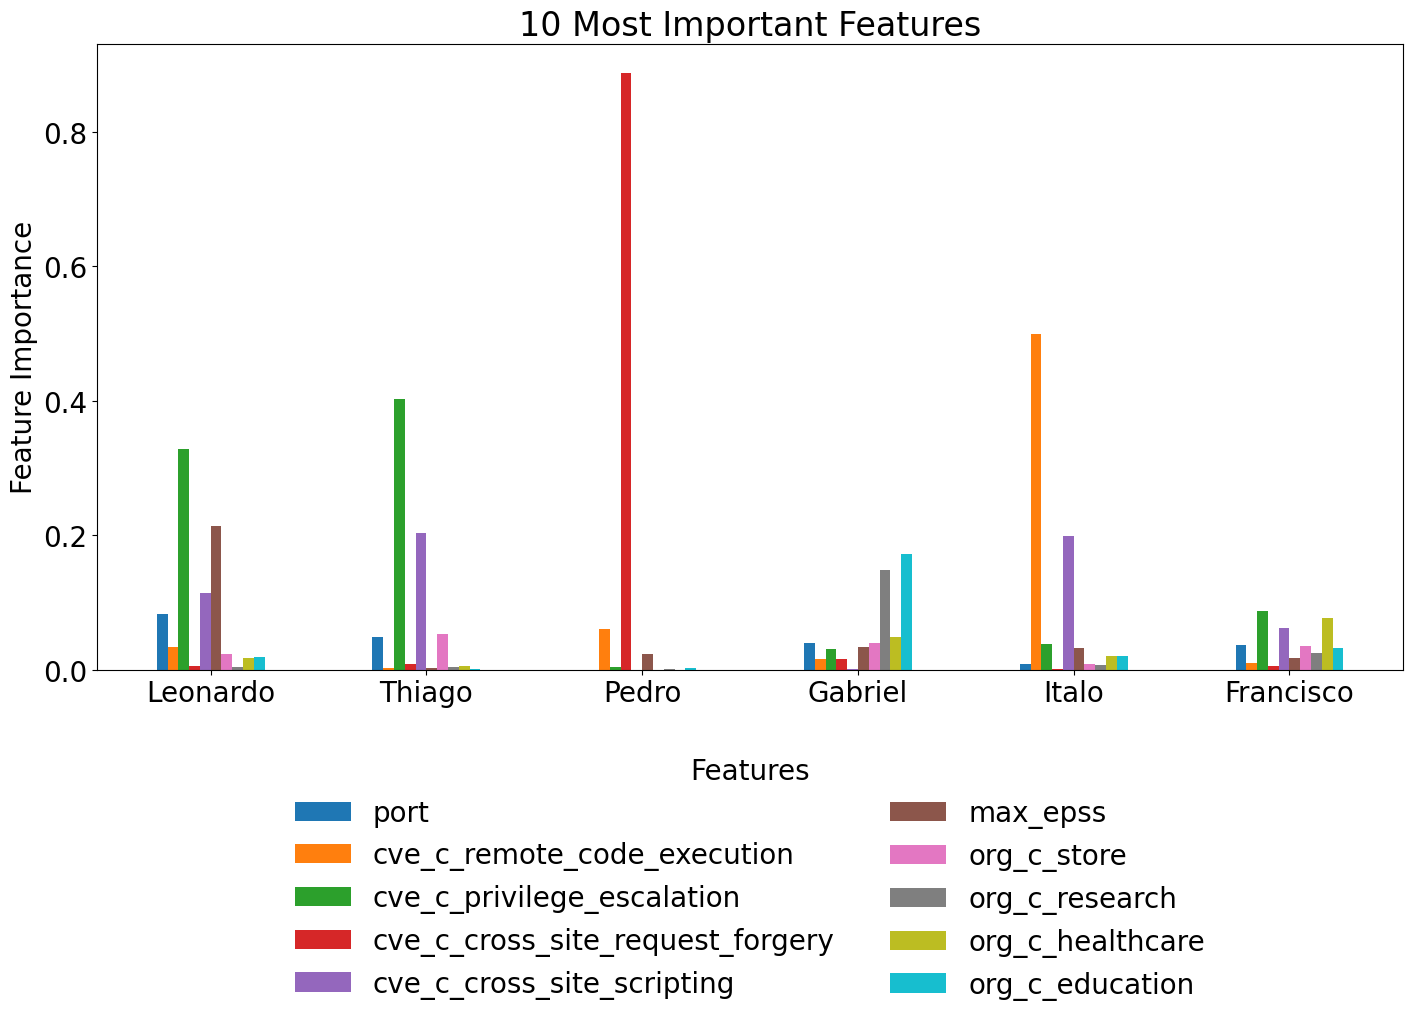

In [9]:
graphics = model_graphics.Graphics()

title = '10 Most Important Features'
output_name = 'groupedbar_10features'
y_label = 'Feature Importance'
legend_title = 'Features'

graphics.groupedbar(df_top10_feature, output_name, title, y_label, legend_title=legend_title, ncol=2)

### Generating a Graph comparing User votes

In [10]:
bins = np.arange(0, 11)

round_user2predictions = {}
frequency = {}

for user, data in user2predictions.items():
    round_user2predictions[user] = [round(num) for num in data]
    frequency[user], _ = np.histogram(data, bins=bins)

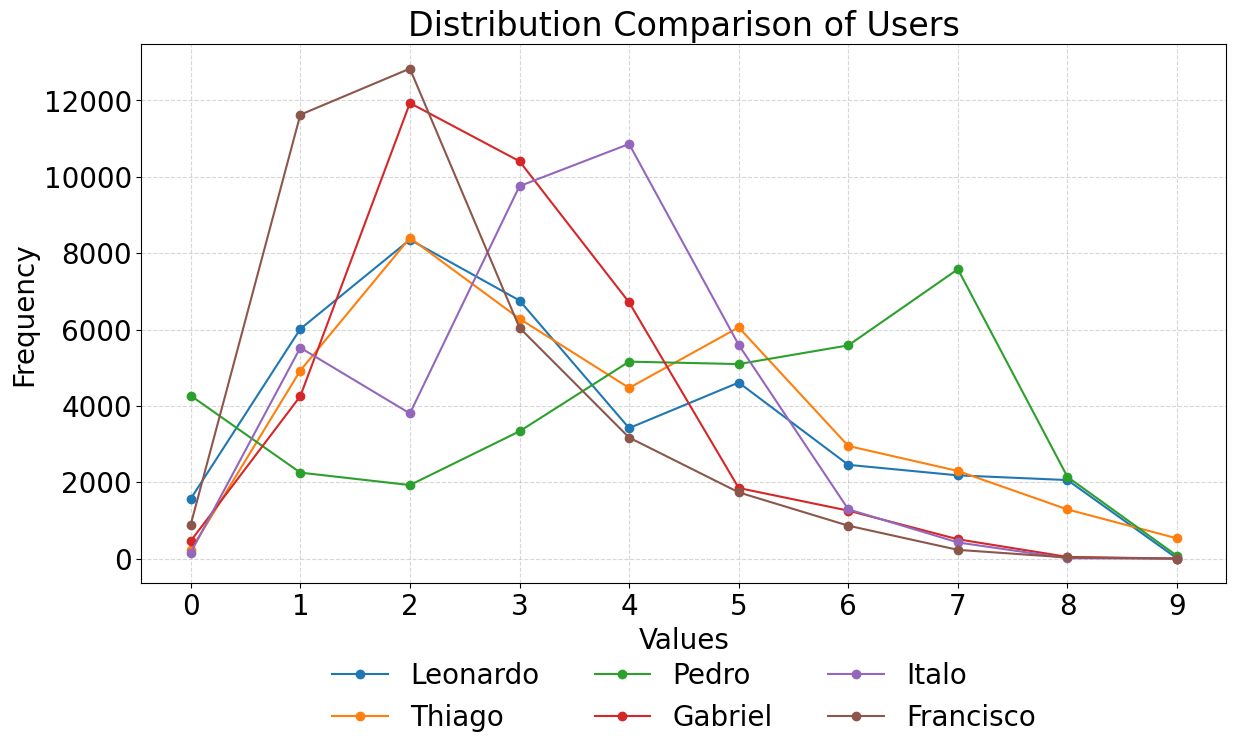

In [11]:
plt.figure(figsize=(14, 7))

for user, counts in frequency.items():
    plt.plot(bins[:-1], counts, marker='o', label=user) 
    
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution Comparison of Users")
plt.xticks(bins[:-1])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)

output_name = 'line_'

output_name = 'scatter_comparisonvotes'
output = os.path.join(f'{current_dir}/model_graphics/', f'{output_name}.pdf')

plt.show()


### Creating a Dataframe of Predictions and Votes

In [12]:
predicted_votes_df = pd.merge(votes_df, shodan_copy_df, on='meta_id')
predicted_votes_df.drop(predicted_votes_df[predicted_votes_df['vote'] == -1].index, inplace=True)

In [13]:
result_dict = {}
for user in users:
    user_data = predicted_votes_df[predicted_votes_df['username'] == user]
    predict_column = f'predicted_vote_{user}'
    tuples = list(zip(user_data['vote'], user_data[predict_column]))
    result_dict[user] = tuples

### Generating a Graph with Votes and Predictions for each User

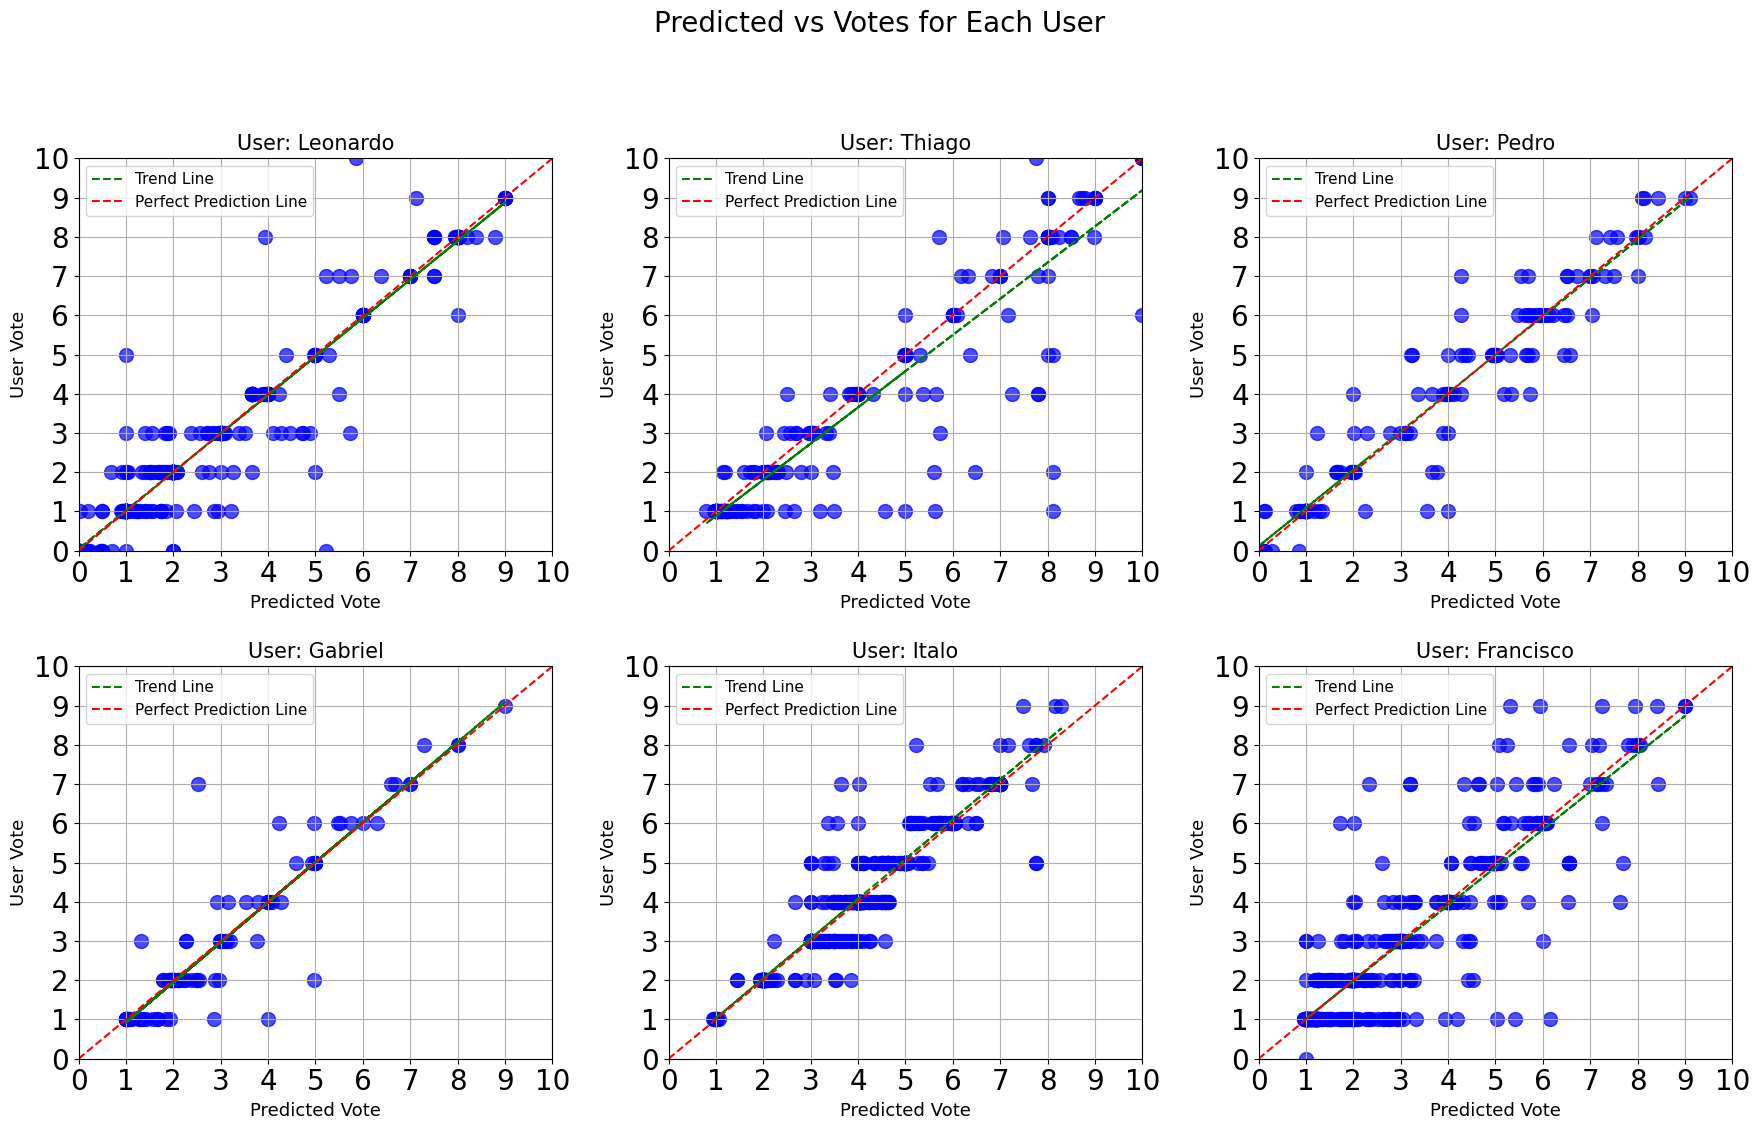

In [14]:
n = (len(result_dict) + 1) // 3
fig, ax = plt.subplots(n, 3, figsize=(18, 6 * n))

ax = ax.flatten()

for i, user in enumerate(users):
    vote, predicted = zip(*result_dict[user])
    
    ax[i].scatter(predicted, vote, color='blue', alpha=0.7, s=100)

    slope, intercept, r_value, p_value, std_err = linregress(predicted, vote)
    regression_line = slope * np.array(predicted) + intercept

    ax[i].plot(predicted, regression_line, color='green', linestyle='--', label='Trend Line')
    ax[i].plot([0, 10], [0, 10], color='red', linestyle='--', label='Perfect Prediction Line')
    ax[i].set_title(f'User: {user}', fontsize=15)
    ax[i].set_xlabel('Predicted Vote', fontsize=13)
    ax[i].set_ylabel('User Vote', fontsize=13)
    ax[i].grid()
    ax[i].legend(fontsize=11)

    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 10)
    ax[i].set_xticks(np.arange(0, 11))
    ax[i].set_yticks(np.arange(0, 11))

fig.suptitle('Predicted vs Votes for Each User', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

output_name = 'scatter_votepredictions'
output = os.path.join(f'{current_dir}/model_graphics/', f'{output_name}.pdf')
plt.savefig(output)
plt.show()

In [15]:
meta_ids_with_all_users = votes_df.groupby('meta_id')['username'].apply(set)
valid_meta_ids = meta_ids_with_all_users[meta_ids_with_all_users == users].index
filtered_df = votes_df[votes_df['meta_id'].isin(valid_meta_ids)]
result = filtered_df.pivot(index='meta_id', columns='username', values='vote').reset_index()
result.columns.name = None
result = result.drop(columns=['meta_id'])

aux_dict = result.to_dict()
new_dict = {}
for i, j in aux_dict.items():
    new_dict[i] = [0] * 11
    for valor in j.values():
        new_dict[i][valor] += 1

result = pd.DataFrame(new_dict)
transpose = result.T.drop(columns=[0])

### User Vote Graph for the same Vulnerabilities

<Figure size 1400x700 with 0 Axes>

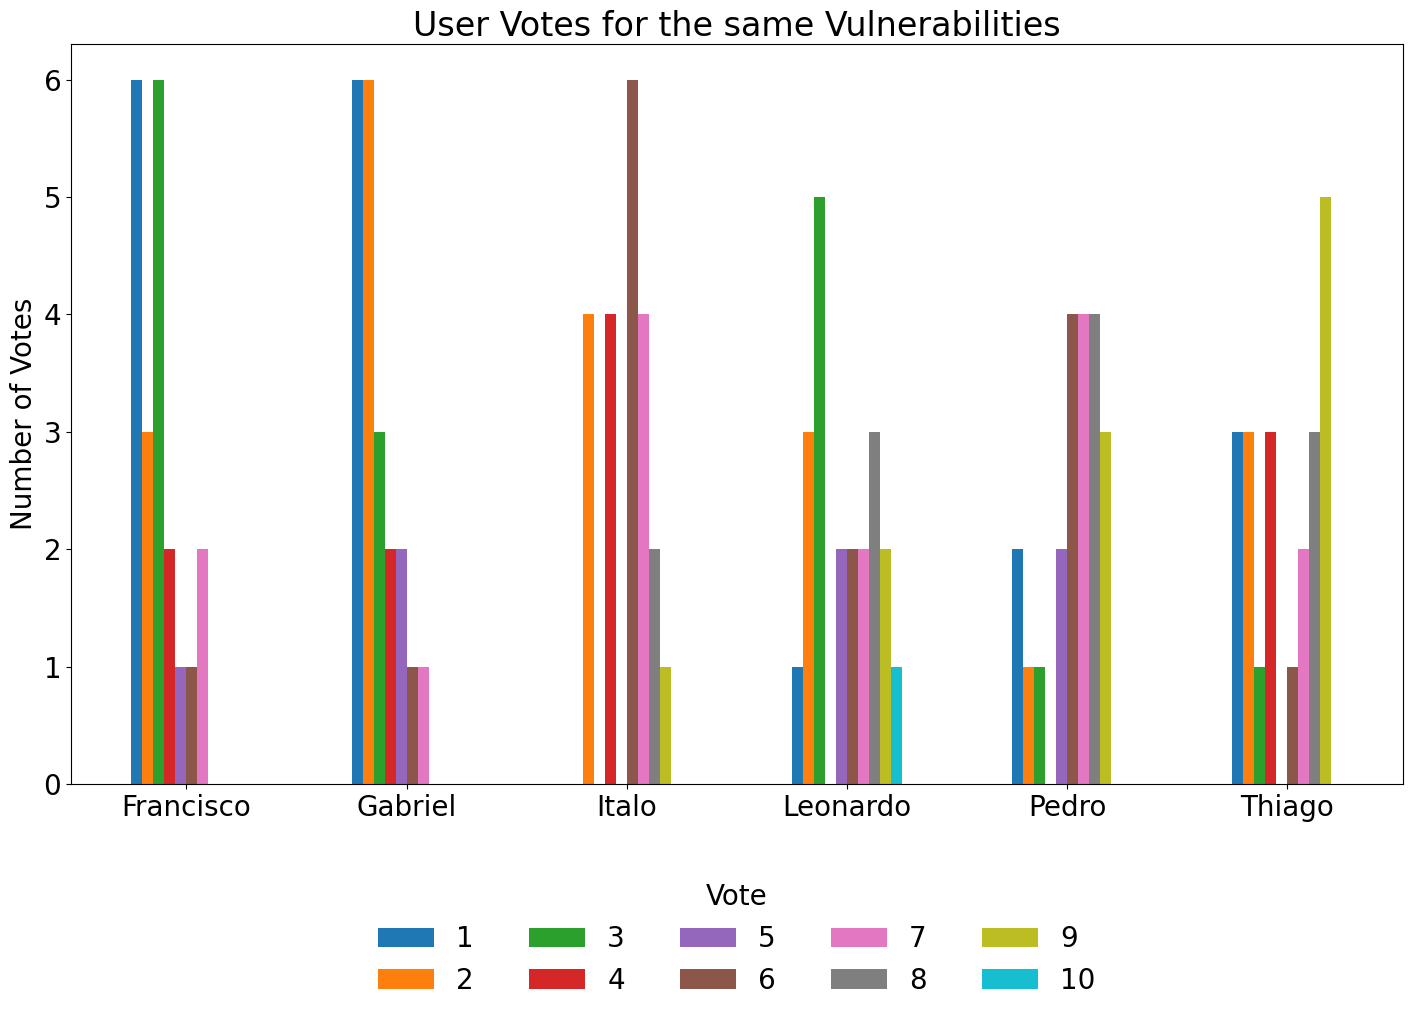

In [16]:
graphics = model_graphics.Graphics()

title = 'User Votes for the same Vulnerabilities'
output_name = 'groupedbar_samevulns'
y_label = 'Number of Votes'
legend_title = 'Vote'

graphics.groupedbar(transpose, output_name, title, y_label, legend_title=legend_title)

### User Vote Graph for all Vulnerabilities

<Figure size 640x480 with 0 Axes>

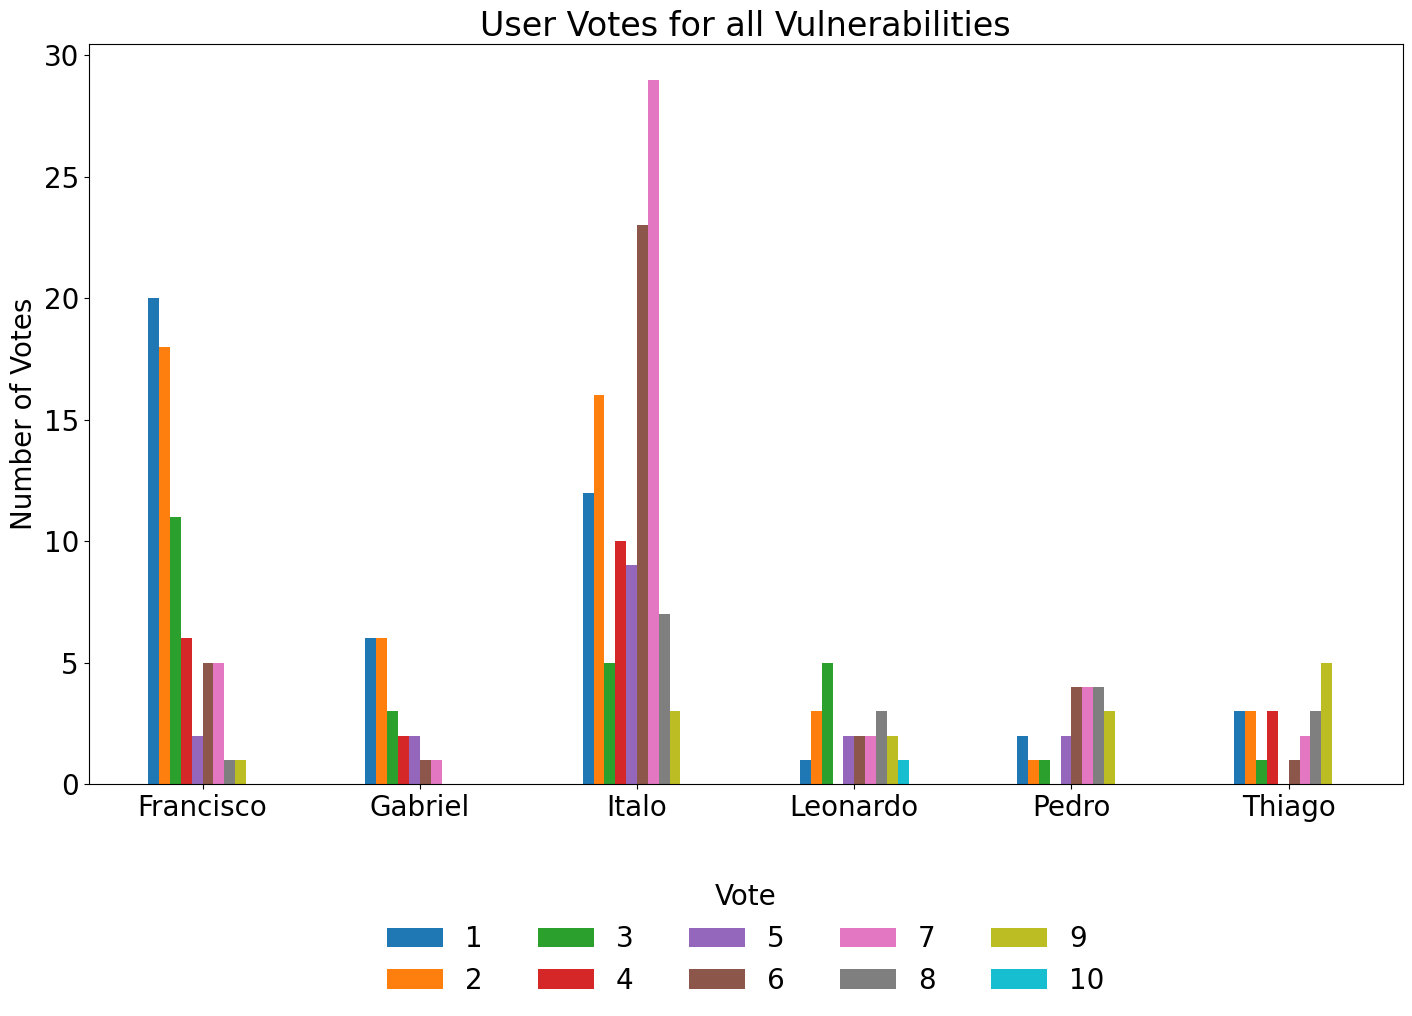

In [17]:
df = votes_df[votes_df['datestr'] >= '2024-11-26']
vote_counts = df.groupby(["username", "vote"]).size().unstack(fill_value=0).drop(columns=-1)

title = 'User Votes for all Vulnerabilities'
output_name = 'groupedbar_allvulns'
y_label = 'Number of Votes'
legend_title = 'Vote'

graphics.groupedbar(vote_counts, output_name, title, y_label, legend_title)

### Model Training with split of Absolute Values ​​and Percentages

In [18]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def training_model(splits: list, users: list, features_df: pd.DataFrame, absolute = False) -> dict:
    average_rmse_dict = {split: [] for split in splits}
    for split in splits:
        for user in users:
            user_accuracies = []

            user_data = features_df[features_df["username"] == user]
            if len(user_data) < 2:
                print(f"Skipping user: {user} due to insufficient data.")
                continue

            for iteration in range(10):
                seed = iteration + 32

                X = user_data.drop(
                    columns=["username", "vote"]
                )
                y = user_data["vote"]

                if absolute == False:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=(1 - split), random_state=seed, shuffle=True
                    )
                else:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=(len(user_data) - split), random_state=seed, shuffle=True
                    )

                model = XGBRegressor(
                    n_estimators=1000,
                    learning_rate=0.1,
                    max_depth=15,
                    verbosity=0,
                    enable_categorical=True,
                    random_state=seed,
                )
                X_train[['port', 'device', 'devicetype']] = X_train[['port', 'device', 'devicetype']].astype('category')
                model.fit(X_train, y_train)

                X_test[['port', 'device', 'devicetype']] = X_test[['port', 'device', 'devicetype']].astype('category')
                y_pred = model.predict(X_test)
                
                y_test_list = y_test.to_list()
                y_pred_7 = []
                y_test_7 = []

                for index, item in enumerate(y_pred):
                    if item >= 7: # valores maiores que 7 (vulnerabilidades mais importantes)
                        y_pred_7.append(y_pred[index])
                        y_test_7.append(y_test_list[index])
                    
                if len(y_pred_7) == 0:
                    continue

                mse = mean_squared_error(y_test, y_pred) # para todos valores
                #mse = mean_squared_error(y_test_7, y_pred_7) # para valores maiores que 7
                rmse = np.sqrt(mse)
                user_accuracies.append(rmse)
            
            average_rmse_dict[split].append(np.mean(user_accuracies))

    return average_rmse_dict

splits_percent = [value / 10 for value in range(1, 10)] # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
splits_int = [value for value in range(5, 51, 5)] # [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

average_rmse_dict_abs = training_model(splits_int, users, features_votes_df, True)
average_rmse_dict_percent = training_model(splits_percent, users, features_votes_df, False)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### RMSE line Graphic for each User

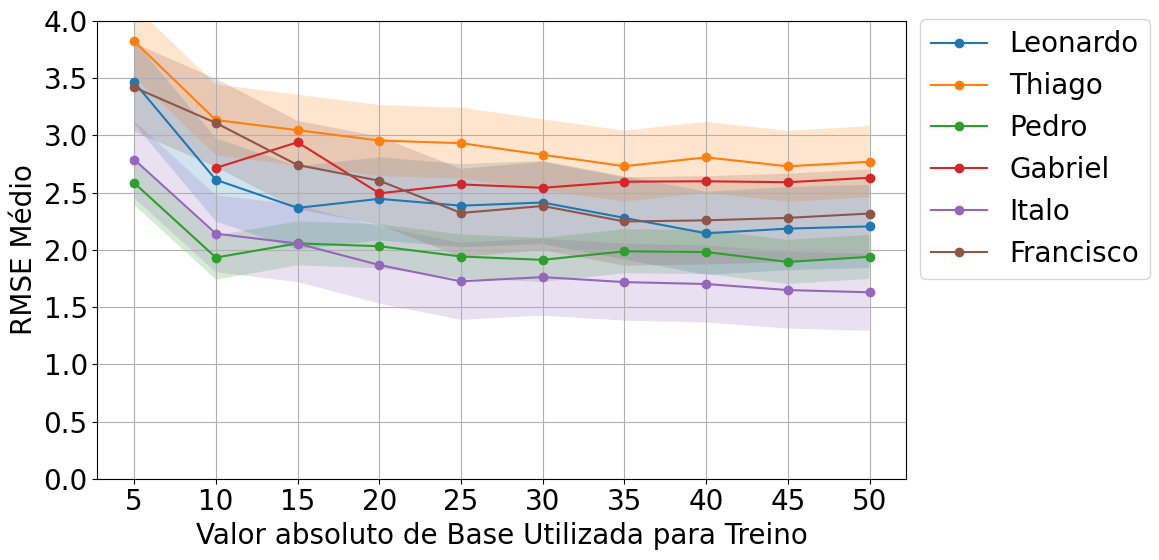

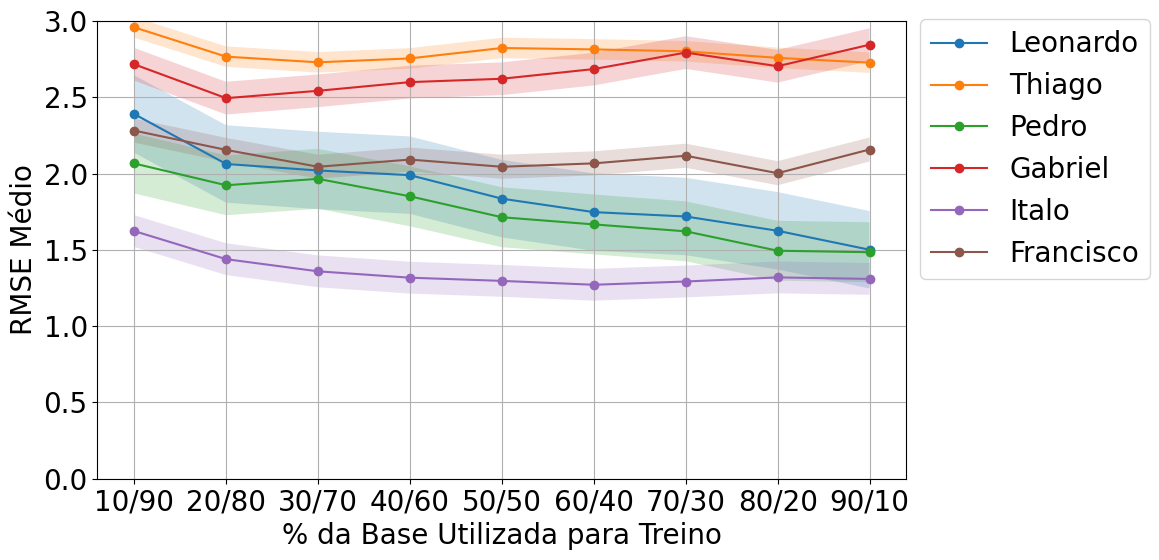

In [19]:
def rmseLineGraphic(average_rmse_dict: dict, users, splits: list, absolute=False):
    logging.getLogger('matplotlib').setLevel(logging.WARNING)
    plt.figure(figsize=(12, 6))

    split2 = list(map(str, splits))
    user_rmse_dict = {name : [] for name in users}
    for param in sorted(average_rmse_dict.keys()):
        values = average_rmse_dict[param]
        for name, value in zip(users, values):
            user_rmse_dict[name].append(value)
    
    aux = 0

    for name, value in user_rmse_dict.items():
        std_dev = np.std(value)
        max_value = max(value)
        if aux < max_value:
            aux = max_value
        
        plt.plot(split2, value, marker='o', label=name)

        plt.fill_between(
            split2,
            np.array(value) - std_dev,
            np.array(value) + std_dev,
            alpha=0.2,
        )
    if absolute == False:
        x_ticks = ["10/90", "20/80", "30/70", "40/60", "50/50", "60/40", "70/30", "80/20", "90/10"]
        x_label = "% da Base Utilizada para Treino"
        output_name = 'rmse_abs'
    else:
        x_ticks = ["5", "10", "15", "20", "25", "30", "35", "40", "45", "50"]
        x_label = "Valor absoluto de Base Utilizada para Treino"
        output_name = 'rmse_percent'

    plt.xticks(split2, x_ticks, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel("RMSE Médio", fontsize=20)
    plt.ylim(bottom=0, top=math.ceil(aux))
    plt.tight_layout()
    plt.legend(fontsize=20, bbox_to_anchor=(1, 1.034))
    plt.grid(True)
    plt.tight_layout()
    plt.tick_params(axis="both", which="major", labelsize=20)
    output = os.path.join(f'{current_dir}/model_graphics/', f'{output_name}.pdf')
    plt.savefig(output, format='pdf')

rmseLineGraphic(average_rmse_dict_abs, users, splits_int, absolute=True)
rmseLineGraphic(average_rmse_dict_percent, users, splits_percent, False)

In [20]:
metaid_df = votes_df.groupby('meta_id').filter(lambda x: len(x) > 1)
metaid_dict_all = metaid_df.groupby('meta_id')['username'].apply(list).to_dict()
metaid_dict_last = {key : item for key, item in metaid_dict_all.items() if len(item) == 6}

In [21]:
matriz = votes_df.pivot_table(
    index='meta_id',
    columns='username',
    values='vote'
).rename(columns=rename_users)
matriz_notnull = matriz.dropna()
correlation_null = matriz_notnull.corr(method='pearson')
correlation_full = matriz.corr(method='pearson')

### Heatmap Graph of the Correlation of Votes between Users

/home/thiagohbs/.local/lib/python3.11/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


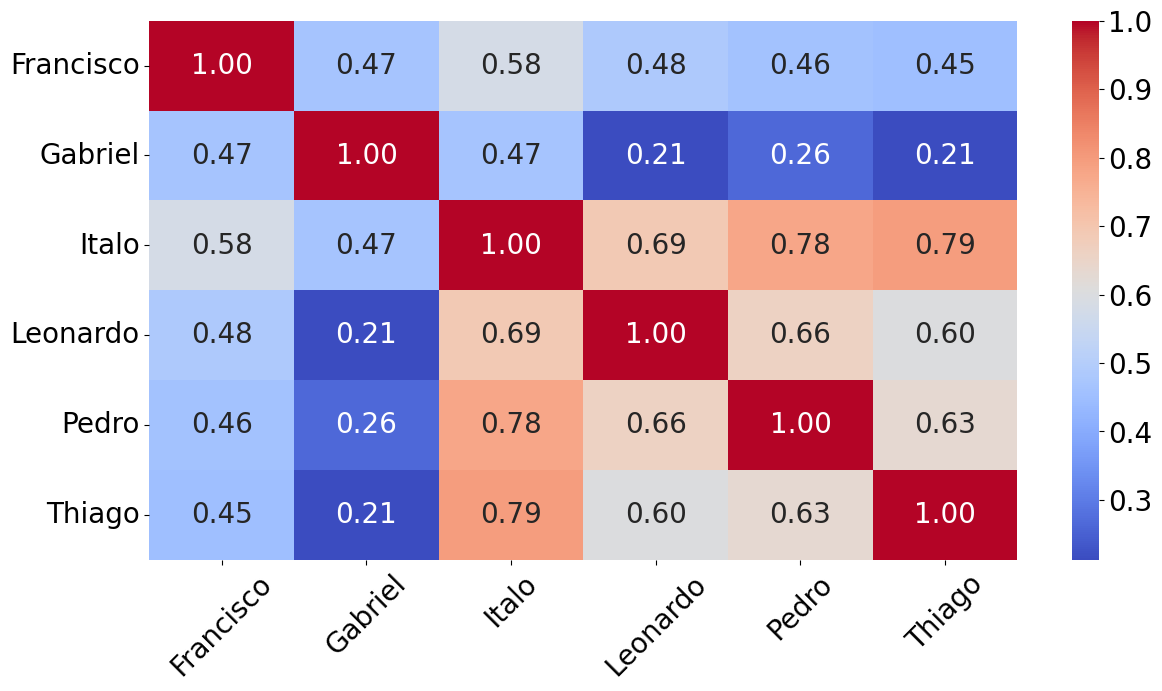

In [22]:
graphic = model_graphics.Graphics()
graphic.heatmap(correlation_null)